In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

from isic_helper import DotDict
from isic_helper import compute_auc, compute_pauc

import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "lgb_v1"
cfg.fold_column = "gkf_fold"

cfg.sampling_ratio = 0.01

In [3]:
id_column = "isic_id"
target_column = "target"
group_column = "patient_id"

ord_categorical_features = [
    "sex",
    "tbp_lv_location",
    "tbp_tile_type",
    "tbp_lv_location_simple",
]

ohe_categorical_features = [
    "anatom_site_general", 
    "attribution",
]

attribution_mapper = {
    "Memorial Sloan Kettering Cancer Center": "MSKCC",
    "ACEMID MIA": "ACEMIDMIA",
    "Department of Dermatology, Hospital Clínic de Barcelona": "DoD_HCB",
    "University Hospital of Basel": "UHB",
    "Frazer Institute, The University of Queensland, Dermatology Research Centre": "FI_TUQ-DRC",
    "Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris": "DoD_UA",
    "ViDIR Group, Department of Dermatology, Medical University of Vienna": "ViDIR"
}

def boosting_norm_feature(df, value_col, group_cols, err=1e-5):
    stats = ["mean", "std"]
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    feature_name = f"{value_col}_patient_norm"
    df[feature_name] = ((df[value_col] - df[f"{value_col}_mean"]) / 
                                       (df[f"{value_col}_std"] + err))
    return df, feature_name

def boosting_feature_engineering(df, err=1e-5):
    df["sex"] = df["sex"].fillna("missing_sex")
    df["anatom_site_general"] = df["anatom_site_general"].fillna("missing_anatom_site_general")
    df["tbp_tile_type"] = df["tbp_tile_type"].map({"3D: white": "white", "3D: XP": "XP"})
    df["attribution"] = df["attribution"].map(attribution_mapper)

    cols_to_norm = [
        "age_approx",
        "clin_size_long_diam_mm",
        "tbp_lv_A", "tbp_lv_Aext",
        "tbp_lv_B", "tbp_lv_Bext",
        "tbp_lv_C", "tbp_lv_Cext",
        "tbp_lv_H", "tbp_lv_Hext",
        "tbp_lv_L", "tbp_lv_Lext",
        "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio",
        "tbp_lv_color_std_mean",
        "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
        "tbp_lv_eccentricity",
        "tbp_lv_minorAxisMM", "tbp_lv_nevi_confidence", "tbp_lv_norm_border",
        "tbp_lv_norm_color", "tbp_lv_perimeterMM",
        "tbp_lv_radial_color_std_max", "tbp_lv_stdL", "tbp_lv_stdLExt",
        "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
        "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
    ]
    numerical_features = cols_to_norm[:]
    for col in cols_to_norm:
        df, feature_name = boosting_norm_feature(df, col, ["patient_id"])
        numerical_features += [feature_name]
    
    df["tbp_lv_H_diff"] = df["tbp_lv_H"] - df["tbp_lv_Hext"]
    numerical_features += ["tbp_lv_H_diff"]

    df["tbp_lv_A_diff"] =  df["tbp_lv_Aext"] - df["tbp_lv_A"]
    df, feature_name = boosting_norm_feature(df, "tbp_lv_A_diff", ["patient_id", "tbp_lv_location"])
    numerical_features += [feature_name]

    df["tbp_lv_B_diff"] =  df["tbp_lv_Bext"] - df["tbp_lv_B"]
    df, feature_name = boosting_norm_feature(df, "tbp_lv_B_diff", ["patient_id", "tbp_lv_location"])
    numerical_features += [feature_name]
    
    df["num_images"] = df["patient_id"].map(df.groupby("patient_id")["isic_id"].count())
    numerical_features += ["num_images"]
    return df, numerical_features

In [4]:
INPUT_PATH = Path("/kaggle/input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False, na_values=["NA"])
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv", low_memory=False, na_values=["NA"])

folds_df = pd.read_csv("/kaggle/input/isic-scd-folds/folds.csv")
train_metadata = train_metadata.merge(folds_df[[id_column, group_column, cfg.fold_column]], on=[id_column, group_column], how="left")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

train_metadata, numerical_features = boosting_feature_engineering(train_metadata)
test_metadata, _ = boosting_feature_engineering(test_metadata)

Train data size: (401059, 56)
Test data size: (3, 44)


In [5]:
cnn_model_names = ["tf_efficientnet_b1_ns", "mobilevitv2_200",
                   "efficientnet_b0", "efficientnet_b1", "efficientnet_b2"]
cnn_versions = ["v1", "v1", 
                "v1", "v2", "v1"]
cnn_modes = ["trainmulti", "trainmulti", 
             "trainbinary", "trainbinary", "trainbinary"]
cnn_paths = [f"/kaggle/input/isic-scd-{model_name.replace('_', '-')}-{version}-{mode}" for model_name, version, mode in zip(cnn_model_names, cnn_versions, cnn_modes)]

all_cnn_oof_columns = []
for idx, path in enumerate(cnn_paths):
    model_name = cnn_model_names[idx]
    version = cnn_versions[idx]
    mode = cnn_modes[idx]
    cnn_oof_train_preds_model_df = pd.read_csv(f"{path}/oof_train_preds_{model_name}_{version}.csv")
    cnn_oof_columns = [col for col in cnn_oof_train_preds_model_df if col.startswith("oof_")]
    cnn_oof_new_columns = [f"{col}_{mode}" for col in cnn_oof_columns]
    columns_mapper = dict(zip(cnn_oof_columns, cnn_oof_new_columns))
    cnn_oof_train_preds_model_df = cnn_oof_train_preds_model_df.rename(columns=columns_mapper)
    all_cnn_oof_columns += cnn_oof_new_columns
    if idx == 0:
        cnn_oof_train_preds_df = cnn_oof_train_preds_model_df[[id_column] + cnn_oof_new_columns].copy()
    else:
        cnn_oof_train_preds_df = cnn_oof_train_preds_df.merge(cnn_oof_train_preds_model_df[[id_column] + cnn_oof_new_columns], on=id_column, how="left")
        assert cnn_oof_train_preds_df.shape[0] == cnn_oof_train_preds_model_df.shape[0]
train_metadata = train_metadata.merge(cnn_oof_train_preds_df, on=id_column, how="left")
numerical_features += all_cnn_oof_columns
cnn_oof_train_preds_df.head()

,isic_id,oof_tf_efficientnet_b1_ns_v1_trainmulti,oof_tf_efficientnet_b1_ns_v1_AKIEC_trainmulti,oof_tf_efficientnet_b1_ns_v1_BCC_trainmulti,oof_tf_efficientnet_b1_ns_v1_BKL_trainmulti,oof_tf_efficientnet_b1_ns_v1_DF_trainmulti,oof_tf_efficientnet_b1_ns_v1_MEL_trainmulti,oof_tf_efficientnet_b1_ns_v1_NV_trainmulti,oof_tf_efficientnet_b1_ns_v1_SCC_trainmulti,oof_tf_efficientnet_b1_ns_v1_VASC_trainmulti,oof_tf_efficientnet_b1_ns_v1_unknown_trainmulti,oof_mobilevitv2_200_v1_trainmulti,oof_mobilevitv2_200_v1_AKIEC_trainmulti,oof_mobilevitv2_200_v1_BCC_trainmulti,oof_mobilevitv2_200_v1_BKL_trainmulti,oof_mobilevitv2_200_v1_DF_trainmulti,oof_mobilevitv2_200_v1_MEL_trainmulti,oof_mobilevitv2_200_v1_NV_trainmulti,oof_mobilevitv2_200_v1_SCC_trainmulti,oof_mobilevitv2_200_v1_VASC_trainmulti,oof_mobilevitv2_200_v1_unknown_trainmulti,oof_efficientnet_b0_v1_trainbinary,oof_efficientnet_b1_v2_trainbinary,oof_efficientnet_b2_v1_trainbinary
0,ISIC_0015845,0.001733,0.000811,0.001191,0.000639,7.258785e-04,0.000123,0.000832,0.000419,1.687060e-05,0.995242,0.000427,0.000081,0.000326,0.000550,0.000172,0.000022,0.000287,0.000078,2.698562e-05,0.998457,0.847101,0.739806,0.811228
1,ISIC_0024200,0.000160,0.000015,0.000099,0.000105,1.860478e-05,0.000045,0.000287,0.000016,4.207151e-06,0.999410,0.000217,0.000023,0.000166,0.000296,0.000047,0.000030,0.000695,0.000021,1.024510e-05,0.998712,0.000033,0.000108,0.000013
2,ISIC_0051648,0.000193,0.000012,0.000021,0.000013,7.361263e-07,0.000166,0.000440,0.000006,7.134003e-08,0.999342,0.000042,0.000005,0.000011,0.000013,0.000001,0.000013,0.000029,0.000018,4.737856e-08,0.999909,0.000005,0.000062,0.000005
3,ISIC_0051896,0.000101,0.000023,0.000018,0.000022,2.897247e-06,0.000073,0.000280,0.000010,2.573446e-07,0.999571,0.000079,0.000006,0.000008,0.000014,0.000001,0.000063,0.000083,0.000008,2.734367e-07,0.999816,0.000027,0.000014,0.000037
4,ISIC_0052026,0.000060,0.000008,0.000042,0.000032,3.375596e-06,0.000010,0.000065,0.000008,1.261671e-07,0.999832,0.000826,0.000173,0.000518,0.000215,0.000034,0.000040,0.000137,0.000268,1.657785e-06,0.998613,0.000042,0.000048,0.000006


In [6]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown="ignore"),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [7]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata[cfg.fold_column]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")
X_train.head()

Total number of columns: 112


,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,age_approx_patient_norm,clin_size_long_diam_mm_patient_norm,tbp_lv_A_patient_norm,tbp_lv_Aext_patient_norm,tbp_lv_B_patient_norm,tbp_lv_Bext_patient_norm,tbp_lv_C_patient_norm,tbp_lv_Cext_patient_norm,tbp_lv_H_patient_norm,tbp_lv_Hext_patient_norm,tbp_lv_L_patient_norm,tbp_lv_Lext_patient_norm,tbp_lv_areaMM2_patient_norm,tbp_lv_area_perim_ratio_patient_norm,tbp_lv_color_std_mean_patient_norm,tbp_lv_deltaA_patient_norm,tbp_lv_deltaB_patient_norm,tbp_lv_deltaL_patient_norm,tbp_lv_deltaLB_patient_norm,tbp_lv_deltaLBnorm_patient_norm,tbp_lv_eccentricity_patient_norm,tbp_lv_minorAxisMM_patient_norm,tbp_lv_nevi_confidence_patient_norm,tbp_lv_norm_border_patient_norm,tbp_lv_norm_color_patient_norm,tbp_lv_perimeterMM_patient_norm,tbp_lv_radial_color_std_max_patient_norm,tbp_lv_stdL_patient_norm,tbp_lv_stdLExt_patient_norm,tbp_lv_symm_2axis_patient_norm,tbp_lv_symm_2axis_angle_patient_norm,tbp_lv_x_patient_norm,tbp_lv_y_patient_norm,tbp_lv_z_patient_norm,tbp_lv_H_diff,tbp_lv_A_diff_patient_norm,tbp_lv_B_diff_patient_norm,num_images,oof_tf_efficientnet_b1_ns_v1_trainmulti,oof_tf_efficientnet_b1_ns_v1_AKIEC_trainmulti,oof_tf_efficientnet_b1_ns_v1_BCC_trainmulti,oof_tf_efficientnet_b1_ns_v1_BKL_trainmulti,oof_tf_efficientnet_b1_ns_v1_DF_trainmulti,oof_tf_efficientnet_b1_ns_v1_MEL_trainmulti,oof_tf_efficientnet_b1_ns_v1_NV_trainmulti,oof_tf_efficientnet_b1_ns_v1_SCC_trainmulti,oof_tf_efficientnet_b1_ns_v1_VASC_trainmulti,oof_tf_efficientnet_b1_ns_v1_unknown_trainmulti,oof_mobilevitv2_200_v1_trainmulti,oof_mobilevitv2_200_v1_AKIEC_trainmulti,oof_mobilevitv2_200_v1_BCC_trainmulti,oof_mobilevitv2_200_v1_BKL_trainmulti,oof_mobilevitv2_200_v1_DF_trainmulti,oof_mobilevitv2_200_v1_MEL_trainmulti,oof_mobilevitv2_200_v1_NV_trainmulti,oof_mobilevitv2_200_v1_SCC_trainmulti,oof_mobilevitv2_200_v1_VASC_trainmulti,oof_mobilevitv2_200_v1_unknown_trainmulti,oof_efficientnet_b0_v1_trainbinary,oof_efficientnet_b1_v2_trainbinary,oof_efficientnet_b2_v1_trainbinary,sex,tbp_lv_location,tbp_tile_type,tbp_lv_location_simple,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_missing_anatom_site_general,anatom_site_general_posterior torso,anatom_site_general_upper extremity,attribution_ACEMIDMIA,attribution_DoD_HCB,attribution_DoD_UA,attribution_FI_TUQ-DRC,attribution_MSKCC,attribution_UHB,attribution_ViDIR
0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0.000000,-0.463758,-0.105245,-0.259588,-0.133360,-1.058597,-0.166866,-0.998143,-0.007955,-0.502041,0.797304,0.550674,-0.676508,1.741324,-1.390228,0.221302,1.055810,0.505632,-0.397698,-0.527611,1.128511,-0.866238,-0.516717,2.172028,-1.408906,-0.394340,-1.340771,-0.254889,0.172754,2.161314,-0.002674,-0.718374,-1.187167,-0.891780,-2.770379,-0.182228,-0.937821,510,0.000019,4.876998e-07,0.000014,0.000015,1.541958e-06,9.513985e-07,5.842453e-07,0.000004,2.531644e-08,0.999964,3.582317e-04,5.451493e-05,1.693506e-04,1.529340e-04,4.560108e-06,4.103017e-05,4.519279e-05,1.478509e-04,3.990715e-07,0.999384,0.001199,3.078171e-06,0.000002,1,12,1,4,0,0,1,0,0,0,0,0,0,0,1,0,0
1,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,

In [8]:
def pauc_80(y_true, y_pred):
    score_value = compute_pauc(y_true, y_pred, min_tpr=0.8)   
    return "pauc_80", score_value, True


params = {
    "objective":        "binary",
    "verbosity":        -1,
    "boosting_type":    "gbdt",
    "metric":           "custom",
    "random_state":     cfg.seed,
    "lambda_l1":        0.08758718919397321, 
    "lambda_l2":        0.0039689175176025465, 
    "learning_rate":    0.01, 
    "max_depth":        4, 
    "num_leaves":       103, 
    "colsample_bytree": 0.8329551585827726, 
    "colsample_bynode": 0.4025961355653304, 
    "bagging_fraction": 0.7738954452473223, 
    "bagging_freq":     4, 
    "min_data_in_leaf": 85, 
    "scale_pos_weight": 2.7984184778875543,
}
num_rounds = 3000
es_rounds = 250
log_rounds = 50

In [9]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.unique(folds)
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]

#     rus = RandomUnderSampler(sampling_strategy=cfg.sampling_ratio, random_state=cfg.seed)
#     X_dev, y_dev = rus.fit_resample(X_dev, y_dev)
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    model = lgb.LGBMClassifier(n_estimators=num_rounds, **params)
    model.fit(X_dev, y_dev,
              eval_set=[(X_val, y_val)], 
              eval_metric=pauc_80,
              callbacks=[
                    early_stopping(stopping_rounds=es_rounds, first_metric_only=True), 
                    log_evaluation(log_rounds)
                ]
             )
    best_num_rounds[f"fold_{fold}"] = model.best_iteration_
    
    val_preds = model.predict_proba(X_val)[:, -1]
    oof_predictions[val_index] = val_preds
    
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    val_pauc_scores[f"fold_{fold}"] = compute_pauc(y_val, val_preds, min_tpr=0.8)
    print("\n")
    
    with open(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt", "wb") as f:
        joblib.dump(model, f)

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_train_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_train_preds_df.to_csv(f"oof_train_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_train_preds_df[target_column], oof_train_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_train_preds_df[target_column], oof_train_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(f"CV PAUC RANGE: ({cv_pauc_avg - cv_pauc_std}, {cv_pauc_avg + cv_pauc_std})")
print(X_train.columns)

Running fold: 1
Training until validation scores don't improve for 250 rounds
[50]	valid_0's pauc_80: 0.18826
[100]	valid_0's pauc_80: 0.188996
[150]	valid_0's pauc_80: 0.191527
[200]	valid_0's pauc_80: 0.191488
[250]	valid_0's pauc_80: 0.1917
[300]	valid_0's pauc_80: 0.191818
[350]	valid_0's pauc_80: 0.191966
[400]	valid_0's pauc_80: 0.192057
[450]	valid_0's pauc_80: 0.192076
[500]	valid_0's pauc_80: 0.192124
[550]	valid_0's pauc_80: 0.192137
[600]	valid_0's pauc_80: 0.192077
[650]	valid_0's pauc_80: 0.192047
[700]	valid_0's pauc_80: 0.192021
[750]	valid_0's pauc_80: 0.191909
Early stopping, best iteration is:
[538]	valid_0's pauc_80: 0.192169
Evaluated only: pauc_80


Running fold: 2
Training until validation scores don't improve for 250 rounds
[50]	valid_0's pauc_80: 0.179543
[100]	valid_0's pauc_80: 0.179589
[150]	valid_0's pauc_80: 0.179866
[200]	valid_0's pauc_80: 0.17977
[250]	valid_0's pauc_80: 0.180266
[300]	valid_0's pauc_80: 0.180739
[350]	valid_0's pauc_80: 0.180667
[400]	v

In [10]:
feature_importances = 0
for fold in all_folds:
    model_filepath = MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt"
    with open(model_filepath, "rb") as f:
        model = joblib.load(f)
    if fold == 1:
        feature_names = model.feature_name_
    feature_importances += model.feature_importances_
feature_importances = feature_importances.astype(np.float32)
feature_importances /= len(all_folds)

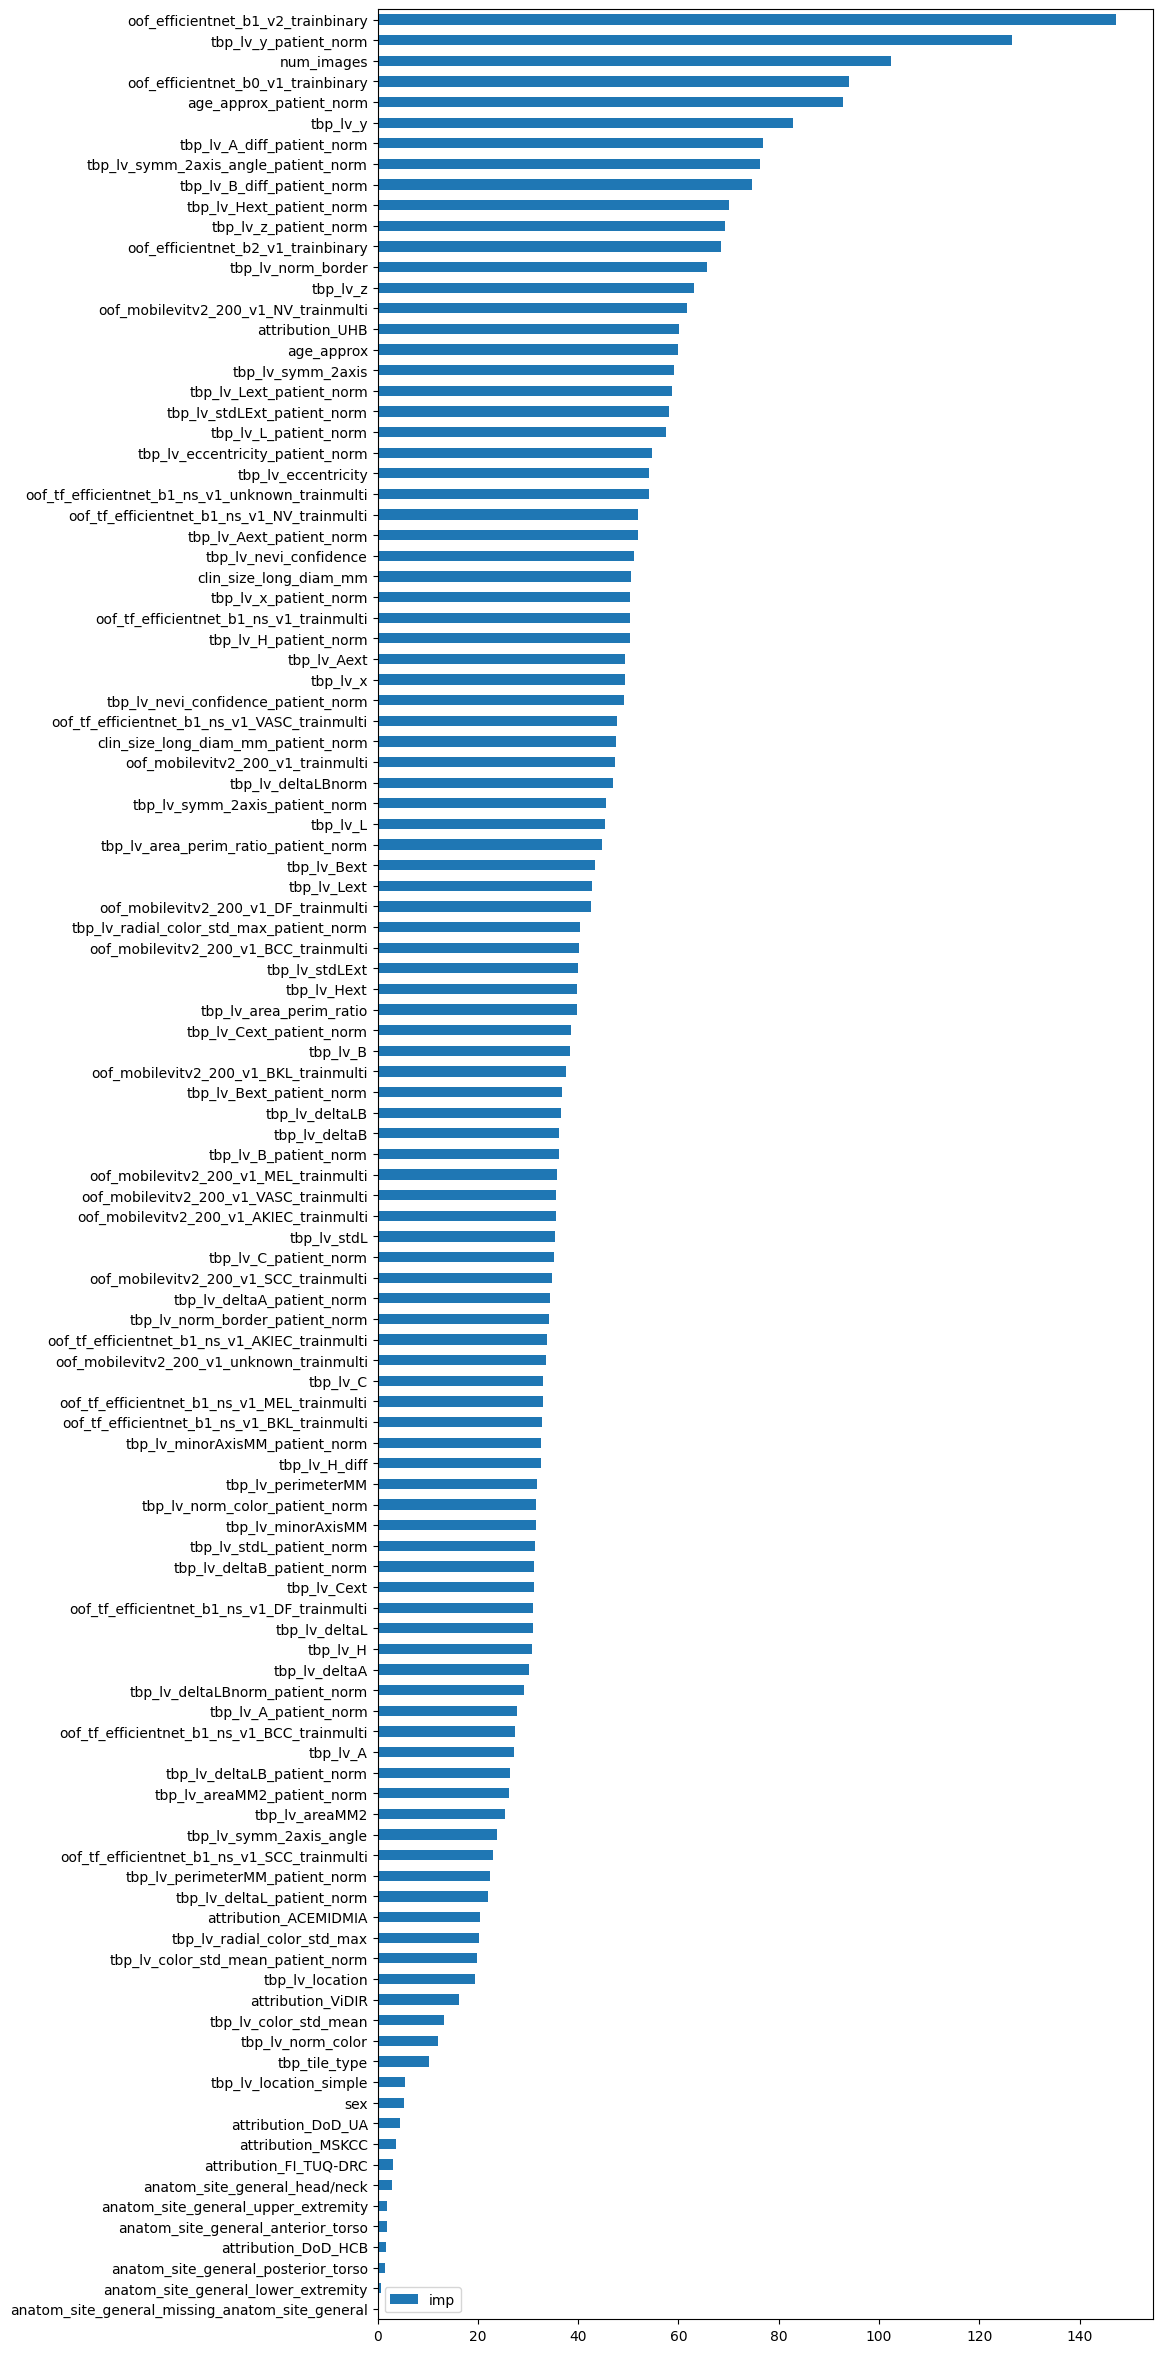

In [11]:
imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 30))
plt.show()

In [12]:
metadata = {
    "config": cfg.__dict__,
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg,
    "cv_auc_std": cv_auc_std,
    "cv_pauc_std": cv_pauc_std
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)

In [13]:
metadata

{'config': {'_temp': False,
  '_key': None,
  '_parent': None,
  'seed': 2022,
  'models_output_dir': 'models',
  'model_name': 'lgb_v1',
  'fold_column': 'gkf_fold',
  'sampling_ratio': 0.01},
 'params': {'objective': 'binary',
  'verbosity': -1,
  'boosting_type': 'gbdt',
  'metric': 'custom',
  'random_state': 2022,
  'lambda_l1': 0.08758718919397321,
  'lambda_l2': 0.0039689175176025465,
  'learning_rate': 0.01,
  'max_depth': 4,
  'num_leaves': 103,
  'colsample_bytree': 0.8329551585827726,
  'colsample_bynode': 0.4025961355653304,
  'bagging_fraction': 0.7738954452473223,
  'bagging_freq': 4,
  'min_data_in_leaf': 85,
  'scale_pos_weight': 2.7984184778875543},
 'num_rounds': 3000,
 'es_rounds': 250,
 'best_num_rounds': {'fold_1': 538,
  'fold_2': 608,
  'fold_3': 29,
  'fold_4': 592,
  'fold_5': 22},
 'val_auc_scores': {'fold_1': 0.9889191383133008,
  'fold_2': 0.9761652437295735,
  'fold_3': 0.9647500655177148,
  'fold_4': 0.9825128539516542,
  'fold_5': 0.9765382039538755},
 'v